In [15]:
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# 数据所在文件夹
base_dir = 'data/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train/train')
validation_dir = os.path.join(base_dir, 'validation/validation')

#Train
train_cats_dir = os.path.join(train_dir, 'cat_min')
train_dogs_dir = os.path.join(train_dir, 'dog_min')

#Validation
validation_cats_dir = os.path.join(validation_dir, 'cat_min')
validation_dogs_dir = os.path.join(validation_dir, 'dog_min')

## tensorflow.keras.applications
- 训练好的模型可直接使用

In [3]:
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
pre_trained_model = ResNet101(input_shape=(75,75,3),
                             include_top = False,
                             weights = 'imagenet')

In [6]:
for layer in pre_trained_model.layers:
    layer.trainable = False

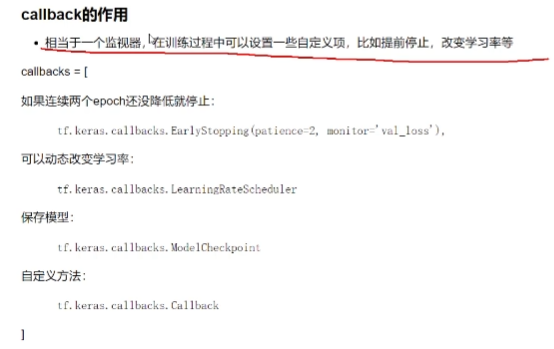

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.95):
            print('\nReached 95% accuracy so cancelling training!')
            self.model.stop_training = True

In [18]:
from tensorflow.keras.optimizers import Adam
#为全连接层做准备
x = layers.Flatten()(pre_trained_model.output)
#加入全连接层并从头训练
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
#输出层
x = layers.Dense(1, activation='sigmoid')(x)
#构建模型序列
model= Model(pre_trained_model.input, x)

model.compile(optimizer = Adam(lr=0.001),
             loss= 'binary_crossentropy',
             metrics=['acc'])

In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [21]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        #文件夹路径
        train_dir,
        #数据图片大小
        target_size=(75,75),
        batch_size=20,
        #one-hot就是categorical，二分类就是binary
        class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(75,75),
        batch_size=20,
        class_mode='binary'
)

Found 3584 images belonging to 2 classes.
Found 358 images belonging to 2 classes.


# 训练模型
- 加入Callback()模块

In [23]:
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=180,# images = batch_size * steps
    epochs=20,
    validation_data=validation_generator,
    validation_steps=18,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/20
180/180 - 70s - loss: 0.9681 - acc: 0.5209 - val_loss: 0.6685 - val_acc: 0.5698
Epoch 2/20
180/180 - 65s - loss: 0.6898 - acc: 0.5508 - val_loss: 0.6608 - val_acc: 0.6620
Epoch 3/20
180/180 - 62s - loss: 0.6863 - acc: 0.5513 - val_loss: 0.6607 - val_acc: 0.6089
Epoch 4/20
180/180 - 60s - loss: 0.6888 - acc: 0.5424 - val_loss: 0.6897 - val_acc: 0.5000
Epoch 5/20
180/180 - 59s - loss: 0.6871 - acc: 0.5391 - val_loss: 0.6640 - val_acc: 0.6145
Epoch 6/20
180/180 - 64s - loss: 0.6856 - acc: 0.5402 - val_loss: 0.6829 - val_acc: 0.5726
Epoch 7/20
180/180 - 63s - loss: 0.6935 - acc: 0.4992 - val_loss: 0.6870 - val_acc: 0.5251
Epoch 8/20
180/180 - 69s - loss: 0.6896 - acc: 0.5232 - val_loss: 0.7015 - val_acc: 0.5000
Epoch 9/20
180/180 - 73s - loss: 0.6882 - acc: 0.5285 - val_loss: 0.6790 - val_acc: 0.6480
Epoch 10/20
180/180 - 73s - loss: 0.6866 - acc: 0.5569 - val_loss: 0.6520 - val_acc: 0.6480
Epoch 11/20
180/180 - 78s - loss: 0.6809 - acc: 0.5703 - val_loss: 0.6822 - val_acc: 0.52

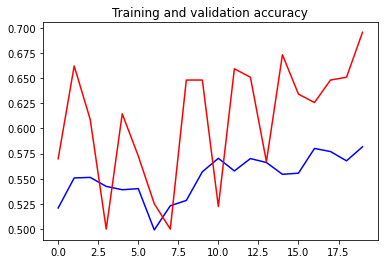

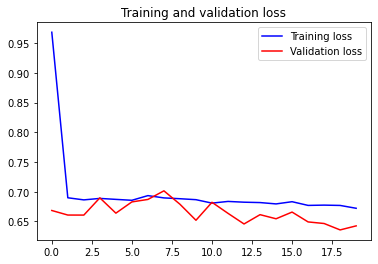

In [27]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
